# VGG 19

In [2]:
from keras.datasets import cifar10

In [37]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

In [4]:
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=.3)

In [6]:
#Dimension of the dataset
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [8]:


#One Hot Encoding
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)


In [9]:
#Verifying the dimension after one hot encoding
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [10]:
# Here, we will perform the image data augmentation. This is the technique that is used to expand the size of a training dataset by creating modified versions of images in the dataset. First, we will define individual instances of ImageDataGenerator for augmentation and then we will fit them with each of the training, test and validation datasets. 

#Image Data Augmentation
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)

val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)

test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True, zoom_range=.1)

In [11]:
#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [12]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)

In [38]:
#Defining the VGG Convolutional Neural Net
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (32,32,3), classes = y_train.shape[1])

In [14]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

In [15]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [18]:
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3)),Dense(128,activation=('relu'))
#model.add(Dropout(.2))
model.add(Dense(10,activation=('softmax'))) 

In [19]:
#Checking the final model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                2

In [21]:
#Initializing the hyperparameters
batch_size= 32
epochs = 50
learn_rate=.001
sgd = SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam = Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
#Training the model
import time
tic = time.time()
model.fit(train_generator.flow(
                    x_train, 
                    y_train, 
                    batch_size= 32),
                    epochs = 1, 
                    steps_per_epoch = x_train.shape[0]//batch_size,
                    validation_data = val_generator.flow(x_val, y_val, 
                    batch_size = 32), 
                    validation_steps = 250, 
                    callbacks=[lrr], 
                    verbose = 1)
toc = time.time()
# training VGG19 deep convolutional neural networks

350/350 [==============================] - 924s 3s/step - loss: 2.3029 - accuracy: 0.0960 - val_loss: 2.3027 - val_accuracy: 0.1006 - lr: 0.0010


In [29]:
print(f'time {toc-tic} seconds')

time 924.2557187080383 seconds


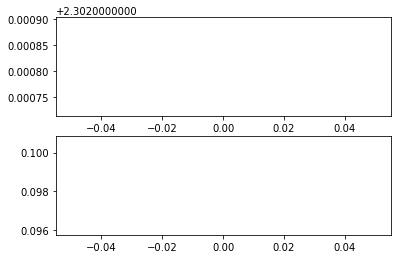

In [30]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [44]:
#Making prediction
y_pred = np.argmax(model.predict(x_test), axis = -1)

313/313 [==============================] - 89s 284ms/step


In [45]:
y_true = np.argmax(y_test,axis=1)

In [46]:
val_pred = np.argmax(model.predict(x_val), axis=-1)

469/469 [==============================] - 132s 282ms/step


In [47]:
#Defining function for confusion matrix plot

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
                #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
